## Install & Import Required Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE

##  Load & Inspect the Dataset

In [3]:
# Load the dataset
file_path = "/workspace/Diploma_Project/updated_clinical_data.csv"  # Update if needed
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,case_id,CPTAC_TCGA_Tissues_data_file_name,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,...,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split,chosen_exam
0,C3L-00004,C3L-00004-26.svs,1,6.0,3,NaN,7,0,1,0,...,0,0,0,1,0,1,1,0,train,C3L-00004-26.npz
1,C3L-00010,C3L-00010-26.svs,1,1.0,3,NaN,3,1,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00010-26.npz
2,C3L-00011,C3L-00011-26.svs,0,5.0,4,1.0,8,0,2,2,...,0,0,0,1,0,1,0,1,train,C3L-00011-26.npz
3,C3L-00026,C3L-00026-21.svs,0,5.0,3,NaN,2,0,1,0,...,0,0,0,1,0,1,0,1,train,C3L-00026-21.npz
4,C3L-00079,C3L-00079-26.svs,1,3.0,3,NaN,8,2,1,0,...,0,0,0,1,0,1,0,0,train,C3L-00079-26.npz


In [4]:
# List of columns to drop
columns_to_drop = ['CPTAC_TCGA_Tissues_data_file_name', 'chosen_exam']  # Replace with your column names

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Display the first few rows after dropping columns
print("\nAfter dropping columns:")
df.head()




After dropping columns:


,case_id,gender,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,vital_status_12,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,Split
0,C3L-00004,1,6.0,3,NaN,7,0,1,0,3,1,0,0,0,1,0,1,1,0,train
1,C3L-00010,1,1.0,3,NaN,3,1,1,0,1,1,0,0,0,1,0,1,0,0,train
2,C3L-00011,0,5.0,4,1.0,8,0,2,2,3,0,0,0,0,1,0,1,0,1,train
3,C3L-00026,0,5.0,3,NaN,2,0,1,0,1,1,0,0,0,1,0,1,0,1,train
4,C3L-00079,1,3.0,3,NaN,8,2,1,0,3,0,0,0,0,1,0,1,0,0,train


## Check Dataset Information & Missing Values

In [5]:
# Get basic info about dataset
df.info()


# Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   case_id                         618 non-null    object 
 1   gender                          618 non-null    int64  
 2   age_diag                        601 non-null    float64
 3   grade                           618 non-null    int64  
 4   cancer_history                  73 non-null     float64
 5   ajcc_path_tumor_pt              618 non-null    int64  
 6   ajcc_path_nodes_pn              618 non-null    int64  
 7   ajcc_clin_metastasis_cm         618 non-null    int64  
 8   ajcc_path_metastasis_pm         618 non-null    int64  
 9   ajcc_path_tumor_stage           618 non-null    int64  
 10  vital_status_12                 618 non-null    int64  
 11  race_Asian                      618 non-null    int64  
 12  race_Black or African American  618 

In [6]:
# Handle Missing Data
imputer = SimpleImputer(strategy="most_frequent")  # Use most_frequent for categorical, median for numerical


In [7]:
# Impute missing categorical values
df["cancer_history"] = imputer.fit_transform(df[["cancer_history"]])


In [8]:
# Impute missing numerical values with median
df["age_diag"] = df["age_diag"].fillna(df["age_diag"].median())


In [9]:
# Replace -1 values in tumor staging with NaN, then fill with mode
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].replace(-1, np.nan)
df["ajcc_path_tumor_stage"] = df["ajcc_path_tumor_stage"].fillna(df["ajcc_path_tumor_stage"].mode()[0])


In [10]:
# Encode Categorical Variables
ordinal_cols = ["ajcc_path_tumor_stage", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm"]
ordinal_encoder = OrdinalEncoder()
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# One-hot encoding for 'gender' only (since race is already one-hot encoded)
df = pd.get_dummies(df, columns=["gender"], drop_first=True)


In [11]:
# Scale Numerical Features using MinMaxScaler
numerical_cols = ["age_diag", "grade", "ajcc_path_tumor_pt", "ajcc_path_nodes_pn",
                  "ajcc_clin_metastasis_cm", "ajcc_path_metastasis_pm", "ajcc_path_tumor_stage"]

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [12]:
# Final Feature Selection
target_col = "vital_status_12"
feature_cols = [col for col in df.columns if col not in ["case_id", "vital_status_12", "Split"]]
X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.int64)

## Train-Test Split

In [13]:
# Handle Class Imbalance using Oversampling (MMIST-ccRCC Approach)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (868, 17), Test Set: (218, 17)


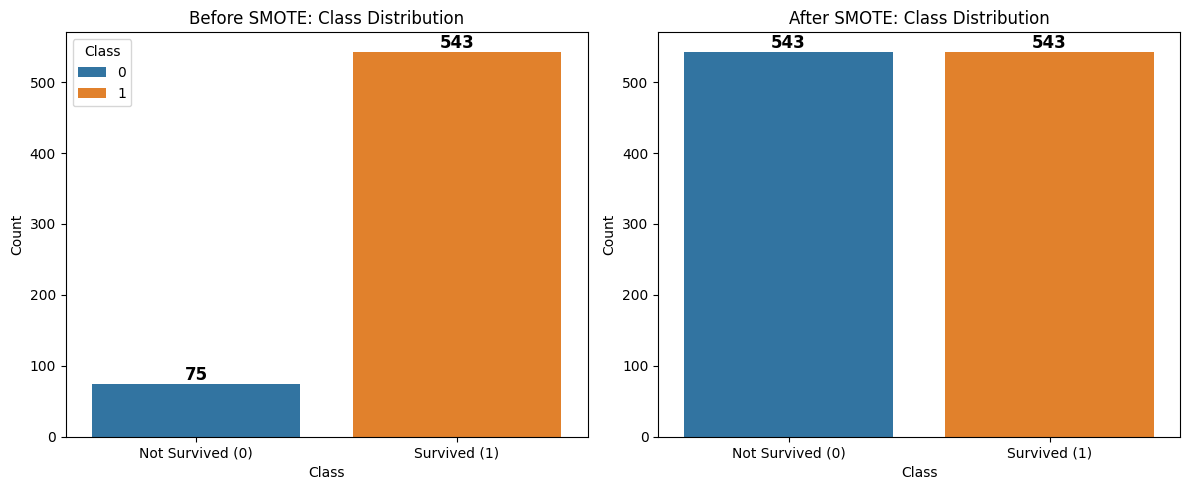

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Original Class Distribution (Before SMOTE)
original_counts = Counter(y)
df_original = pd.DataFrame.from_dict(original_counts, orient='index', columns=['Count']).reset_index()
df_original.columns = ['Class', 'Count']

# Resampled Class Distribution (After SMOTE)
resampled_counts = Counter(y_resampled)
df_resampled = pd.DataFrame.from_dict(resampled_counts, orient='index', columns=['Count']).reset_index()
df_resampled.columns = ['Class', 'Count']

# Plot Before & After Distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.barplot(data=df_original, x="Class", y="Count", ax=ax[0], hue="Class", dodge=False)
ax[0].set_title("Before SMOTE: Class Distribution")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for container in ax[0].containers:
    for bar in container:
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width() / 2., height + 5, f'{int(height)}',
                   ha='center', fontsize=12, fontweight='bold')

# After SMOTE
sns.barplot(data=df_resampled, x="Class", y="Count", ax=ax[1], hue="Class", dodge=False)
ax[1].set_title("After SMOTE: Class Distribution")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["Not Survived (0)", "Survived (1)"])
for container in ax[1].containers:
    for bar in container:
        height = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width() / 2., height + 5, f'{int(height)}',
                   ha='center', fontsize=12, fontweight='bold')


plt.legend([], [], frameon=False)  # Remove redundant legend
plt.tight_layout()
plt.savefig("smote_class_distribution.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


In [16]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Extract original case_id values before SMOTE
original_case_ids = df["case_id"].tolist()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Identify the number of synthetic samples
num_original = len(y)  # Original dataset size
num_synthetic = len(y_resampled) - num_original  # New synthetic samples created

# Generate synthetic IDs
synthetic_ids = [f"syn_{i}" for i in range(1, num_synthetic + 1)]

# Merge original case IDs with synthetic ones
case_ids_balanced = original_case_ids + synthetic_ids

# Convert X_resampled to DataFrame and add case_id & target variable
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced["vital_status_12"] = y_resampled  # Add target column
df_balanced["case_id"] = case_ids_balanced  # Add case_id (original + synthetic)

# Display the DataFrame instead of saving it to a CSV file
print("Balanced Dataset:")
display(df_balanced)

Balanced Dataset:


,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,gender_1,vital_status_12,case_id
0,0.714286,0.500000,1.0,0.636364,0.333333,0.666667,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.0,1.0,1,C3L-00004
1,0.000000,0.500000,1.0,0.272727,0.666667,0.666667,0.333333,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,1,C3L-00010
2,0.571429,0.750000,1.0,0.727273,0.333333,1.000000,1.000000,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,0,C3L-00011
3,0.571429,0.500000,1.0,0.181818,0.333333,0.666667,0.333333,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1,C3L-00026
4,0.285714,0.500000,1.0,0.727273,1.000000,0.666667,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,0,C3L-00079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.714286,0.704225,1.0,0.818182,0.636150,0.000000,0.666667,0.666667,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,0.0,0,syn_464
1082,0.428571,0.645848,1.0,0.886380,0.333333,0.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,1.0,0,syn_465
1083,0.514164,0.500000,1.0,0.509401,0.333333,0.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,1.0,0,syn_466
1084,0.703430,0.615501,1.0,0.272727,0.333333,0.000000,0.666667,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.537994,0.0,1.0,0,syn_467


In [17]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Extract original case_id values before SMOTE
original_case_ids = df["case_id"].tolist()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Identify the number of synthetic samples
num_original = len(y)  # Original dataset size
num_synthetic = len(y_resampled) - num_original  # New synthetic samples created

# Generate synthetic IDs
synthetic_ids = [f"syn_{i}" for i in range(1, num_synthetic + 1)]

# Merge original case IDs with synthetic ones
case_ids_balanced = original_case_ids + synthetic_ids

# Convert X_resampled to DataFrame and add case_id & target variable
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced["vital_status_12"] = y_resampled  # Add target column
df_balanced["case_id"] = case_ids_balanced  # Add case_id (original + synthetic)


# Convert X_resampled to DataFrame and add case_id & target variable
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced["vital_status_12"] = y_resampled  # Add target column
df_balanced["case_id"] = case_ids_balanced  # Add case_id (original + synthetic)

# Display the DataFrame instead of saving it to a CSV file
print("balanced_clinical_data_with_ids:")
display(df_balanced)




balanced_clinical_data_with_ids:


,age_diag,grade,cancer_history,ajcc_path_tumor_pt,ajcc_path_nodes_pn,ajcc_clin_metastasis_cm,ajcc_path_metastasis_pm,ajcc_path_tumor_stage,race_Asian,race_Black or African American,race_Hispanic or Latino,race_White,race_other,VHL_mutation,PBMR1_mutation,TTN_mutation,gender_1,vital_status_12,case_id
0,0.714286,0.500000,1.0,0.636364,0.333333,0.666667,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.0,1.0,1,C3L-00004
1,0.000000,0.500000,1.0,0.272727,0.666667,0.666667,0.333333,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,1,C3L-00010
2,0.571429,0.750000,1.0,0.727273,0.333333,1.000000,1.000000,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,0,C3L-00011
3,0.571429,0.500000,1.0,0.181818,0.333333,0.666667,0.333333,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1,C3L-00026
4,0.285714,0.500000,1.0,0.727273,1.000000,0.666667,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,0,C3L-00079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.714286,0.704225,1.0,0.818182,0.636150,0.000000,0.666667,0.666667,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,0.0,0,syn_464
1082,0.428571,0.645848,1.0,0.886380,0.333333,0.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,1.0,0,syn_465
1083,0.514164,0.500000,1.0,0.509401,0.333333,0.000000,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,-1.0,-1.000000,-1.0,1.0,0,syn_466
1084,0.703430,0.615501,1.0,0.272727,0.333333,0.000000,0.666667,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.537994,0.0,1.0,0,syn_467


In [18]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Extract original case_id values before SMOTE
original_case_ids = df["case_id"].values  # Original patient IDs
X_original = df[feature_cols].values.astype(np.float32)
y_original = df["vital_status_12"].values.astype(np.int64)

# Apply SMOTE to generate synthetic data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_original, y_original)

# Identify number of synthetic samples
num_original = len(y_original)  # Original dataset size
num_synthetic = len(y_resampled) - num_original  # New synthetic samples

# Extract indices of synthetic samples (these come after the original data in SMOTE output)
synthetic_indices = np.arange(num_original, len(y_resampled))

# Map synthetic samples to nearest real patient ID
# Nearest original sample (in feature space) used to generate synthetic data
nearest_real_indices = smote.nn_k_.kneighbors(X_resampled[synthetic_indices], return_distance=False)[:, 0]
synthetic_case_ids = original_case_ids[nearest_real_indices]  # Assign same case_id as closest original sample

# Merge original and synthetic case IDs
case_ids_balanced = np.concatenate([original_case_ids, synthetic_case_ids])

# Convert X_resampled to DataFrame and add case_id & target variable
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced["vital_status_12"] = y_resampled  # Add target column
df_balanced["case_id"] = case_ids_balanced  # Assign patient IDs

# Save to CSV
balanced_csv_path = "/content/balanced_clinical_data_with_patient_ids.csv"
df_balanced.to_csv(balanced_csv_path, index=False)

print(f"Balanced dataset saved at: {balanced_csv_path}")


Balanced dataset saved at: /content/balanced_clinical_data_with_patient_ids.csv


,case_id,Count
0,C3N-00177,17
1,C3L-01288,15
2,C3L-00581,15
3,C3L-00360,14
4,C3L-00583,13
...,...,...
613,TCGA-B0-5709,1
614,TCGA-B0-5710,1
615,TCGA-B0-5711,1
616,TCGA-B0-5712,1


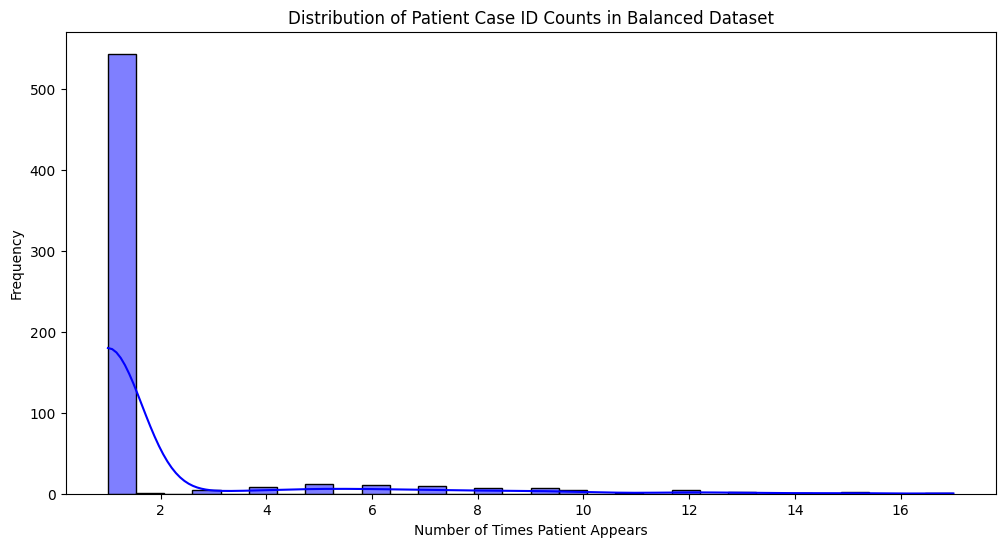

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load the balanced dataset
balanced_csv_path = "/content/balanced_clinical_data_with_patient_ids.csv"
df_balanced = pd.read_csv(balanced_csv_path)

# Count occurrences of each case_id
patient_counts = df_balanced["case_id"].value_counts().reset_index()
patient_counts.columns = ["case_id", "Count"]

# Display the full table (scrollable output)
display(patient_counts)  # Displays all patients' data


# Plot the distribution of case_id appearances
plt.figure(figsize=(12, 6))
sns.histplot(patient_counts["Count"], bins=30, kde=True, color="blue")

# Formatting
plt.xlabel("Number of Times Patient Appears")
plt.ylabel("Frequency")
plt.title("Distribution of Patient Case ID Counts in Balanced Dataset")

# Show the plot
plt.show()


In [20]:
# Count patients who appear more than once
num_more_than_once = (patient_counts["Count"] > 1).sum()

# Total patients
total_patients = len(patient_counts)

print(f"Total patients: {total_patients}")
print(f"Patients appearing more than once: {num_more_than_once}")
print(f"Percentage of repeated patients: {num_more_than_once / total_patients * 100:.2f}%")


Total patients: 618
Patients appearing more than once: 75
Percentage of repeated patients: 12.14%


,case_id,Count
0,C3N-00177,17
1,C3L-01288,15
2,C3L-00581,15
3,C3L-00360,14
4,C3L-00583,13
...,...,...
70,C3L-01281,3
71,C3N-00305,3
72,C3L-01607,3
73,C3L-01302,3


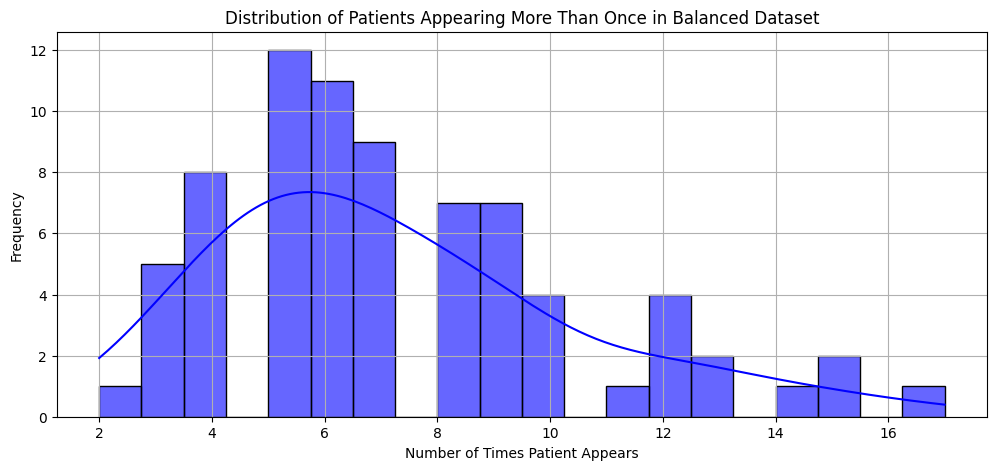

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Filter patients who appear more than once
repeated_patients = patient_counts[patient_counts["Count"] > 1]

# Display the table of repeated patients
import IPython.display as disp
disp.display(repeated_patients)

# Plot distribution of repeated patients
plt.figure(figsize=(12, 5))
sns.histplot(repeated_patients["Count"], bins=20, kde=True, color="blue", alpha=0.6)

plt.xlabel("Number of Times Patient Appears")
plt.ylabel("Frequency")
plt.title("Distribution of Patients Appearing More Than Once in Balanced Dataset")
plt.grid(True)

plt.show()


In [26]:
import pandas as pd

# Load datasets
balanced_data = pd.read_csv("/content/balanced_clinical_data_with_patient_ids.csv")  # Contains synthetic & original case_ids with vital_status_12
slide_data = pd.read_csv("/content/dataset_with_labels.csv")  # Contains case_id and slide_id mappings

# Extract mapping of case_id to slide_id from dataset_with_labels.csv
slide_mapping = slide_data.set_index("case_id")["slide_id"].to_dict()

# Assign slide_id to balanced dataset
balanced_data["slide_id"] = balanced_data["case_id"].map(slide_mapping)

# Rename vital_status_12 as label
balanced_data.rename(columns={"vital_status_12": "label"}, inplace=True)

# Ensure all synthetic case_ids have corresponding slide_id
# If a synthetic case_id does not exist in slide_mapping, assign a slide_id with a placeholder
for index, row in balanced_data.iterrows():
    if pd.isna(row["slide_id"]):  # If slide_id is missing
        balanced_data.at[index, "slide_id"] = f"{row['case_id']}-XX"  # Assigning placeholder suffix

# Select relevant columns for final dataset
final_data = balanced_data[["case_id", "slide_id", "label"]]

# Print preview
print("Preview of updated dataset with case_id, slide_id, and label:")
print(final_data.head())

# Save the updated dataset
final_data.to_csv("/content/final.csv", index=False)

print("\n✅ Final dataset saved as: /content/final.csv")


Preview of updated dataset with case_id, slide_id, and label:
     case_id      slide_id  label
0  C3L-00004  C3L-00004-26      1
1  C3L-00010  C3L-00010-26      1
2  C3L-00011  C3L-00011-26      0
3  C3L-00026  C3L-00026-21      1
4  C3L-00079  C3L-00079-26      0

✅ Final dataset saved as: /content/final.csv


🔹 Total patients in dataset: 618
🔹 Patients appearing more than once: 75
🔹 Percentage of repeated patients: 12.14%



,case_id,Count
0,C3N-00177,17
1,C3L-01288,15
2,C3L-00581,15
3,C3L-00360,14
4,C3L-00583,13
...,...,...
70,C3L-01281,3
71,C3N-00305,3
72,C3L-01607,3
73,C3L-01302,3


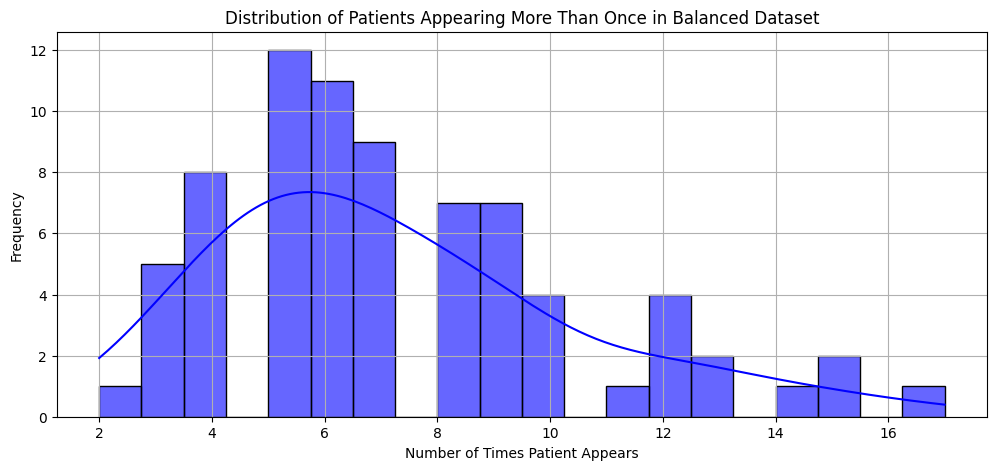

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load the newly balanced dataset
balanced_data = pd.read_csv("/content/final.csv")

# Count how many times each patient (case_id) appears
patient_counts = balanced_data["case_id"].value_counts().reset_index()
patient_counts.columns = ["case_id", "Count"]

# Filter patients who appear more than once
repeated_patients = patient_counts[patient_counts["Count"] > 1]

# Display total number of repeated patients
total_repeated = len(repeated_patients)
total_patients = len(patient_counts)
percentage_repeated = (total_repeated / total_patients) * 100

print(f"🔹 Total patients in dataset: {total_patients}")
print(f"🔹 Patients appearing more than once: {total_repeated}")
print(f"🔹 Percentage of repeated patients: {percentage_repeated:.2f}%\n")

# Display the table of repeated patients
display(repeated_patients)

# Plot distribution of repeated patients
plt.figure(figsize=(12, 5))
sns.histplot(repeated_patients["Count"], bins=20, kde=True, color="blue", alpha=0.6)

plt.xlabel("Number of Times Patient Appears")
plt.ylabel("Frequency")
plt.title("Distribution of Patients Appearing More Than Once in Balanced Dataset")
plt.grid(True)

plt.show()


## Define an Improved PyTorch Dataset & Model

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Create PyTorch Dataset
class ClinicalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataloaders
batch_size = 32
train_dataset = ClinicalDataset(X_train, y_train)
test_dataset = ClinicalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Improved MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, 2)  # Binary classification (Survival/No Survival)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_size=X.shape[1]).to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 6.0]).to(device))  # Weighted loss for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

##  Train the Model

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop with better logging
num_epochs = 50
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    correct, total, running_loss = 0, 0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Reduce learning rate if loss does not improve
    scheduler.step(epoch_loss)

    # Print loss & accuracy every 5 epochs instead of every epoch
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")




/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/50 - Loss: 0.2964, Accuracy: 0.5703
Epoch 10/50 - Loss: 0.2710, Accuracy: 0.6740
Epoch 15/50 - Loss: 0.2353, Accuracy: 0.7293
Epoch 20/50 - Loss: 0.2225, Accuracy: 0.7719
Epoch 25/50 - Loss: 0.2071, Accuracy: 0.7915
Epoch 30/50 - Loss: 0.1959, Accuracy: 0.7938
Epoch 35/50 - Loss: 0.2267, Accuracy: 0.7857
Epoch 40/50 - Loss: 0.1685, Accuracy: 0.8260
Epoch 45/50 - Loss: 0.1822, Accuracy: 0.8088
Epoch 50/50 - Loss: 0.1874, Accuracy: 0.8191


## Plot Training Performance (Accuracy & Loss Curves)

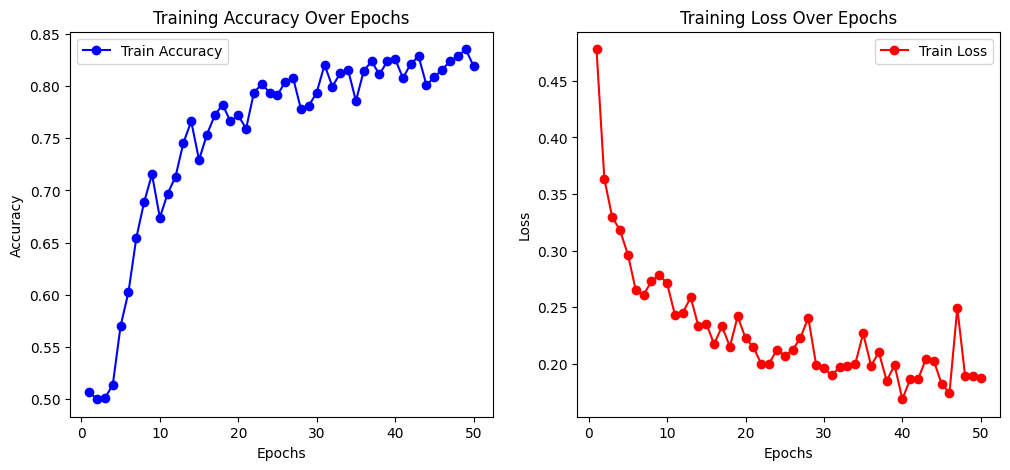

In [46]:
# Plot Train Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.show()


##  Evaluate Model on Test Data

In [47]:
# Evaluate on test set
model.eval()  # Set model to evaluation mode
correct, total, running_loss = 0, 0, 0.0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)[:, 1]  # Get probability for positive class

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Compute final test accuracy and loss
test_loss = running_loss / len(test_loader)
test_accuracy = correct / total

print(f"\n🔹 Test Loss: {test_loss:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\n🔹 Classification Report:\n", classification_report(all_labels, all_preds))



🔹 Test Loss: 0.1464
🔹 Test Accuracy: 0.8853

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.87       109
           1       0.83      0.97      0.89       109

    accuracy                           0.89       218
   macro avg       0.90      0.89      0.88       218
weighted avg       0.90      0.89      0.88       218



## Plot Evaluation Metrics (Confusion Matrix & ROC Curve)

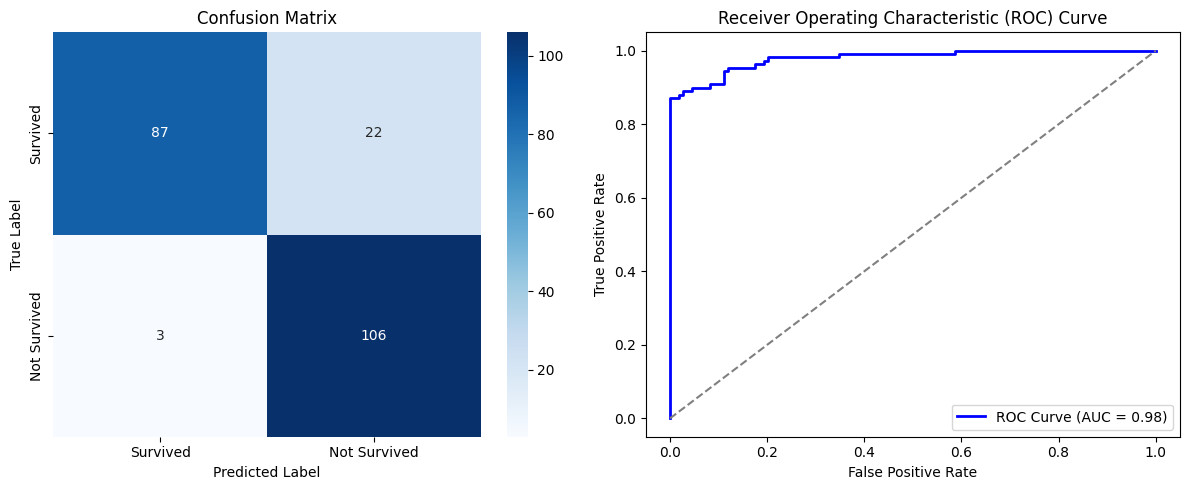

In [48]:
plt.figure(figsize=(12, 5))

# Confusion Matrix on the left
plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Survived", "Not Survived"], yticklabels=["Survived", "Not Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# ROC Curve on the right
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
